In [ ]:
'''
shell model prepared for launching as Bogdan wants it. (well, as I understand it)
'''

In [ ]:
# importing important stuff

In [1]:
import numpy as np
import scipy as sp
import h5py
import math
from IPython import display
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from IPython.display import HTML
from scipy.special import ive 
from scipy.integrate import ode
from IPython.display import clear_output
import time
import copy as cp
import os 
import json
import imp
import gc


In [2]:
def dump_electrostatic(y,ys,hs):
    ys.append(y)
    phi = syst.getPhi(y)
    chi = syst.getChi(phi)
    h = syst.getH(y, chi)
    hs.append(h)

def dump_electromagnetic(y,ys,hs):
    ys.append(y)
    phi = syst.getPhi(y)
    A = syst.getA(y)
    B = syst.getB(y)
    chiPhiB, chiA, chi1 = syst.getChi(phi, A, B)
    h = syst.getH(y, chiPhiB, chiA, chi1)
    hs.append(h)

In [3]:
BASE_PATH = '..'
SAVE_PATH = 'save'
JSON_PATH = 'parameters'
SOURCE_PATH = 'src'


In [4]:
# parameter file .json format
json_file = os.path.join(BASE_PATH,JSON_PATH,'parameters.json')
with open(json_file) as file_object:
    parameters = json.load(file_object)

In [5]:
# let's look at the parameters we have set
print(json.dumps(parameters, indent=4))

{
    "system": {
        "electromagnetic": true,
        "beta": 1.0,
        "number_of_species": 2,
        "mass": [
            0.0005446623093681918,
            1.0
        ],
        "density": [
            1.0,
            1.0
        ],
        "charge": [
            -1.0,
            1.0
        ],
        "temperature": [
            1.0,
            1.0
        ],
        "dissipation_m": 0.1,
        "dissipation_k": 0.1,
        "force": 0
    },
    "geometry": {
        "filename": "spaceConfiguration6.h5",
        "n_hermite_modes": 100
    },
    "save_file": {
        "save": true,
        "filename": "linear_check_3.h5",
        "stride": 10
    },
    "initial": {
        "from_file": true,
        "filename": "linear_check_2.h5"
    },
    "simulation_parameters": {
        "dt": 0.0001,
        "dump": 500,
        "progress_bar": true,
        "timesteps": 500000,
        "linear_flag": true,
        "nonlinear_flag": false,
        "dissipation_flag": false

In [6]:
sys.path.append(os.path.join(BASE_PATH,SOURCE_PATH))
import CROS
imp.reload(CROS)

<module 'CROS' from '../src/CROS.py'>

In [7]:
# simulation type: electrostatic or electromagnetic?
if not parameters['system']['electromagnetic']:
    import electrostatic as system
    dump_data = dump_electrostatic
if parameters['system']['electromagnetic']:
    import electromagnetic as system
    dump_data = dump_electromagnetic
imp.reload(system) #needed for debugging purposes; can be deleted

<module 'electromagnetic' from '../src/electromagnetic.py'>

In [8]:
# defining initial conditions functions, because it is convinient
def initial_conditions(sys):
    y0 = ((0.5-np.random.random(sys.shape))+1.j*(0.5-np.random.random(sys.shape)))
    y0[:,3:,:] = 0
    #y0 = y0 * np.exp(-np.asarray([x for x in range(sys.m)]))[None,:,None,None]
    return y0

In [9]:
# defining our system of interest with the parameter file
syst = system.Functions(parameters)


Linear term: True
Nonlinear term: False
Dissipative term: False



In [10]:
syst.shape

(48, 100, 2, 2)

In [11]:
# reading important parameters for integration
dt = parameters['simulation_parameters']['dt']               # timestep 
timesteps = parameters['simulation_parameters']['timesteps'] # number of timesteps
dump = parameters['simulation_parameters']['dump']           # how often to save the fields

FROM_FILE = parameters['initial']['from_file']               # do we read initial distribution function from a file or not
if FROM_FILE:                                                # if yes      
    load_filename = parameters['initial']['filename']
    with h5py.File(os.path.join('..',SAVE_PATH, load_filename),'r') as f:
        y0 = f['g'][-1,...];
else:                                                        # if no, initialize initial condition from function defined earlier
    y0 = initial_conditions(syst)
    
SAVE = parameters['save_file']['save']                       # want to save simulation to file? okey-dokey
if SAVE:
    FILENAME = parameters['save_file']['filename']

In [12]:
# initializing solver in an elegant way with timestep, RHS function and initial conditions
cros = CROS.CROS(dt = dt,func = syst.func,y0 = y0)

In [13]:
# initializing our fields
ys = []
hs = []
y = y0.copy()
PROGRESS_BAR = parameters['simulation_parameters']['progress_bar']
if PROGRESS_BAR:
    import tqdm
    sim_range = tqdm.tqdm(range(timesteps),miniters=100)
else:
    sim_range = range(timesteps)
#starting solving loop
for i in sim_range:
    
    # dump fields if time to dump fields
    if i%dump == 0:
        dump_data(y,ys,hs)
        if not PROGRESS_BAR:
            print('integrating timestep t = {}'.format(i))
        
    # propagate in time
    y = cros.make_step(y)
    
    # garbage collector to save memory. call every 10 steps
    if i%10 == 0:
        gc.collect()

100%|██████████| 500000/500000 [2:11:46<00:00, 63.24it/s]  


In [58]:
with h5py.File(os.path.join('..',SAVE_PATH, 'dissipation_and_forcing_0_1_continue_from_0_4.h5'),'r') as f:
        gs = f['g'][...];
        hs = f['h'][...];

In [14]:
gs = np.array(ys)
hs = np.array(hs)

In [15]:
# save data into file (if you want)
if SAVE:
    file = os.path.join(BASE_PATH, SAVE_PATH, FILENAME) 
    with h5py.File(file,'w') as f:
        f.create_dataset("g", data = gs)
        f.create_dataset("h", data = hs)
        f.create_dataset("dt", data = dt)
        f.create_dataset("timesteps", data = timesteps)

In [57]:
free_energy

array([498.95653786, 498.95653806, 498.95653827, 498.95653848,
       498.9565387 ])

Text(0.5, 1.0, 'free energy conservation')

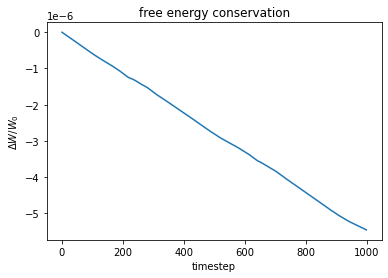

In [16]:
#compute free energy; this quantity should be conserved
free_energy = np.abs(np.sum(hs*np.conj(gs[:,...]),axis = (1,2,3,4)))
# relative change in free energy
x = np.arange(free_energy.size)
plt.plot(x,(free_energy[:]-free_energy[0])/free_energy[0])
plt.xlabel('timestep')
plt.ylabel(r'$\Delta W/W_0$')
plt.title('free energy conservation')
#plt.plot([0.002*x**2 for x in range(50)])
#plt.yscale('log')
#plt.xscale('log')

In [17]:
%matplotlib inline
from ipywidgets import interactive, fixed
def plot_m_space(time,sps):
    xGrid = np.linspace(1,syst.m,syst.m)
    plt.figure(figsize = (12,10))
    #plt.loglog([x for x in range(1,syst.m+1)],(np.sum(np.abs((gs)[time,:,:,:,sps])**2,axis = (0,2))))
    #plt.loglog([x for x in range(1,syst.m+1)],(np.sum(np.abs((hs)[time,:,:,:,sps])**2,axis = (0,2))),linewidth=4.0)
    plt.loglog([x for x in range(1,syst.m+1)],(np.sum(np.abs((np.conj(gs)*hs)[time,:,:,:,sps]),axis = (0,2))),linewidth=4.0)
    #plt.loglog([x for x in range(1,sys.m+1)],(np.sum(np.abs((y1)[time,:,:,sps])**2,axis = 0)))
    #plt.loglog([x for x in range(1,sys.m+1)],(np.abs(y[time,9,:,sps])**2))
    #plt.loglog([x for x in range(1,sys.m+1)],(np.sum(np.abs((h)[time,:,:,sps])**2,axis = 0)))
    #plt.loglog([x for x in range(1,sys.m+1)],(np.abs((h)[time,100,:,sps])**2))
    #plt.loglog([x for x in range(1,sys.m+1)],(np.abs((y)[time,-1,:,sps])**2))
    #plt.loglog([x for x in range(1,sys.m+1)],(np.abs(h[time,:,:,sps])**2))
    #plt.loglog([x for x in range(1,sys.m+1)],np.sum(np.abs((res1)[time,:,:,sps])**2,axis = 0))
    #plt.loglog([x for x in range(1,sys.m+1)],np.sum(np.abs((resH1)[time,:,:,sps])**2,axis = 0))
    plt.loglog((xGrid),(2/(np.sqrt(xGrid)**5)),'k--',linewidth=2.0,label = r'$k^{-5/2}$')
    plt.ylim([1e-4,1e5])
    plt.xlabel('Hermite moment',fontsize = 18)
    plt.ylabel(r'$\sum_{k,l}|h_{e,l}^m(\mathbf{k},t)|^2$',fontsize = 18)
    plt.legend(fontsize = 18)

In [18]:
w=interactive(plot_m_space,time = (0,hs.shape[0]-1),sps=(0,1))

In [19]:
w

interactive(children=(IntSlider(value=499, description='time', max=999), IntSlider(value=0, description='sps',…

In [20]:
# animation
# taken from 
# http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [21]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

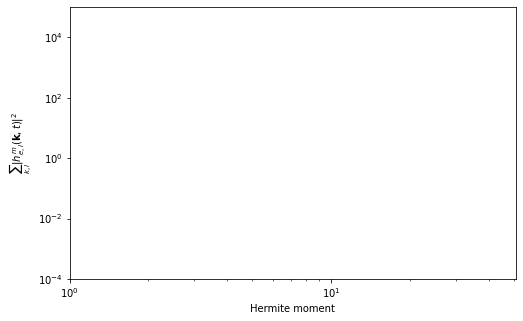

In [22]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(8,5))

ax.set_xlim((1, 51))
ax.set_ylim([1e-4,1e5])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Hermite moment',fontsize = 10)
ax.set_ylabel(r'$\sum_{k,l}|h_{e,l}^m(\mathbf{k},t)|^2$',fontsize = 10)
line, = ax.plot([], [], lw=2)

In [23]:
def init():
    line.set_data([], [])
    return (line,)

In [24]:
g_anim = (np.sum(np.abs((gs)[:,:,:,:,0])**2,axis = (1,3)))

In [25]:
g_anim.shape

(1000, 100)

In [26]:
def animate(i):
    xRange = [x for x in range(1,syst.m+1)]
    y = g_anim[i,:]
    line.set_data(xRange, y)
    return (line,)

In [27]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)


In [28]:
anim

In [29]:
writervideo = animation.FFMpegWriter(fps=30)
anim.save('no_dissip_test_3.mp4', writer=writervideo)
plt.close()

In [66]:
def plot_m_space(time,sps):
    xGrid = np.linspace(1,syst.m,syst.m)
    f = plt.figure(figsize = (8,5))
    plt.loglog([x for x in range(1,syst.m+1)],(np.sum(np.abs((gs)[time,:,:,:,sps])**2,axis = (0,2))),linewidth=2.0)
    plt.ylim([1e-4,1e5])
    plt.xlabel('Hermite moment',fontsize = 10)
    plt.ylabel(r'$\sum_{k,l}|h_{e,l}^m(\mathbf{k},t)|^2$',fontsize = 10)
    #plt.legend(fontsize = 18)
    return f

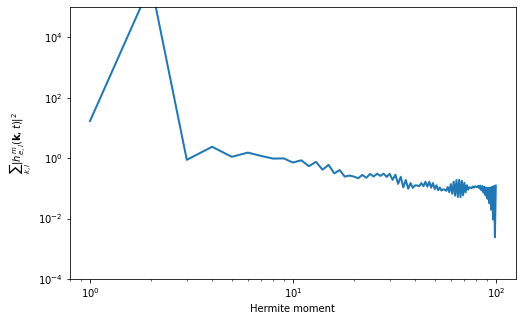

In [67]:
timeslice = 750
f = plot_m_space(timeslice,0)

In [81]:
f.savefig('m_spec_no_diss_{}.pdf'.format(timeslice),bbox = 'tight')

/home/alcauchy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  """Entry point for launching an IPython kernel.


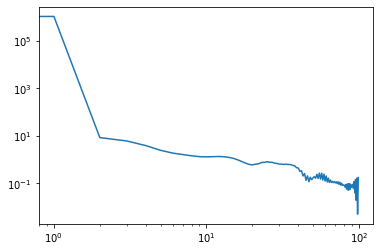

In [68]:
plt.loglog(np.sum(np.abs(y0)**2,axis = (0,2,3)))

In [69]:
file = os.path.join(BASE_PATH, SAVE_PATH, 'start_point_dis_0_1.h5') 
with h5py.File(file,'w') as f:
    f.create_dataset("g", data = y0)

/home/alcauchy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  


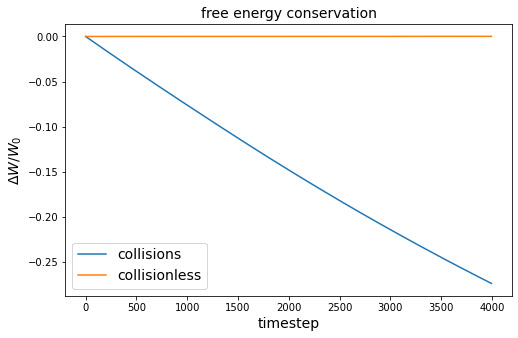

In [102]:
#compute free energy; this quantity should be conserved
f = plt.figure(figsize=(8,5))
free_energy = np.abs(np.sum(hs*np.conj(gs[:,...]),axis = (1,2,3,4)))
# relative change in free energy
plt.plot(np.arange(free_energy.size)*4,(free_energy[:]-free_energy[0])/free_energy[0],label = 'collisions')
plt.plot(np.arange(free_energy.size)*4,(free_energy_no_diss[:]-free_energy_no_diss[0])/free_energy_no_diss[0],label = 'collisionless')
plt.legend(fontsize = 14)
plt.xlabel('timestep',fontsize = 14)
plt.ylabel(r'$\Delta W/W_0$',fontsize = 14)
plt.title('free energy conservation',fontsize = 14)
#plt.plot([0.002*x**2 for x in range(50)])
#plt.yscale('log')
#plt.xscale('log')
f.savefig('free_enrergy.pdf',bbox = 'tight')

In [39]:
def plot_m_space_mean(sps):
    xGrid = np.linspace(1,syst.m,syst.m)
    f = plt.figure(figsize = (8,5))
    plt.loglog([x for x in range(1,syst.m+1)],(np.mean(np.sum(np.abs((hs)[:,:,:,:,sps])**2,axis = (1,3)),axis = 0)),linewidth=2.0)
    plt.loglog((xGrid),(2/(np.sqrt(xGrid))),'k--',linewidth=2.0,label = r'$k^{-5/2}$')
    plt.ylim([1e-4,1e6])
    plt.xlabel('Hermite moment',fontsize = 10)
    plt.ylabel(r'$\sum_{k,l}|h_{e,l}^m(\mathbf{k},t)|^2$',fontsize = 10)
    #plt.legend(fontsize = 18)
    return f

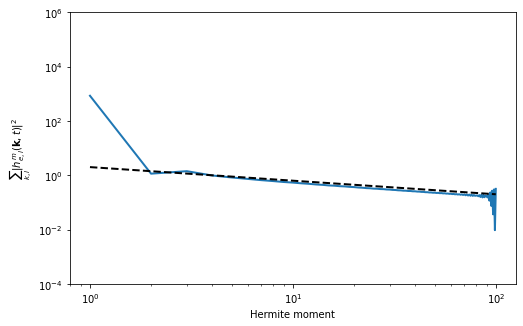

In [40]:
f = plot_m_space_mean(0)

In [ ]:
def plot_m_space_mean(sps):
    xGrid = np.linspace(1,syst.m,syst.m)
    f = plt.figure(figsize = (8,5))
    plt.loglog([x for x in range(1,syst.m+1)],(np.mean(np.sum(np.abs((hs)[:,:,:,:,sps])**2,axis = (1,3)),axis = 0)),linewidth=2.0)
    plt.loglog((xGrid),(2/(np.sqrt(xGrid))),'k--',linewidth=2.0,label = r'$k^{-5/2}$')
    plt.ylim([1e-4,1e6])
    plt.xlabel('Hermite moment',fontsize = 10)
    plt.ylabel(r'$\sum_{k,l}|h_{e,l}^m(\mathbf{k},t)|^2$',fontsize = 10)
    #plt.legend(fontsize = 18)
    return f